In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch

In [2]:
data = pd.read_csv('./data.csv')
Y = np.array(data['y']==1)
X = data.drop(['y','Unnamed: 0'],axis=1)
#del X['Unnamed: 0']
print(np.shape(X), np.shape(Y))

(11500, 178) (11500,)


In [3]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3)
print(np.shape(X_train), np.shape(X_test))

scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(8050, 178) (3450, 178)


In [5]:
hidden_size = 20
net = torch.nn.Sequential(torch.nn.Linear(178, hidden_size),torch.nn.ReLU(),torch.nn.Linear(hidden_size, 10))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2) #lr: learning rate

In [6]:
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)
inputs = torch.autograd.Variable(torch.Tensor(X_train).float())
targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
for epoch in range(epochs):
    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    inputs_test = torch.autograd.Variable(torch.Tensor(X_test).float())
    out_test = net(inputs_test)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

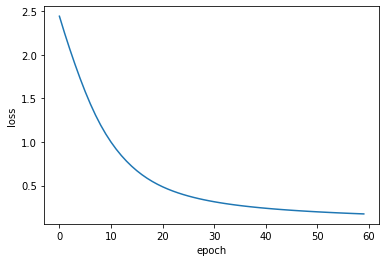

In [7]:
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('loss_red.png')

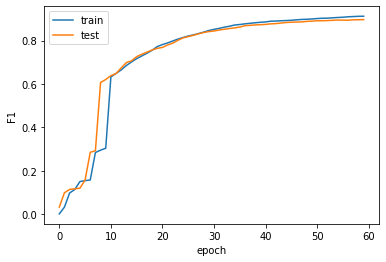

In [8]:
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()
plt.savefig('f1_red.png')

In [9]:
X_new = np.expand_dims(X_train, 1) # necesario para que las dimensiones sean [batch, channel, width]
feature_maps = torch.autograd.Variable(torch.Tensor(X_new).float())
print(feature_maps.size())

n = torch.nn.Conv1d(1, 10, 8, stride=1) # in-channels = 1, out-channels = 10, kernel=8
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.MaxPool1d(kernel_size=3)
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.Conv1d(10, 1, 2, stride=1)
feature_maps = n(feature_maps)
print(feature_maps.size())

torch.Size([8050, 1, 178])
torch.Size([8050, 10, 171])
torch.Size([8050, 10, 57])
torch.Size([8050, 1, 56])


In [13]:
model = torch.nn.Sequential(torch.nn.Conv1d(1, 10, kernel_size=8, stride=1),torch.nn.MaxPool1d(kernel_size=3),
                            torch.nn.Conv1d(10, 1, kernel_size=2, stride=1),torch.nn.Linear(56, 2))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)
for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

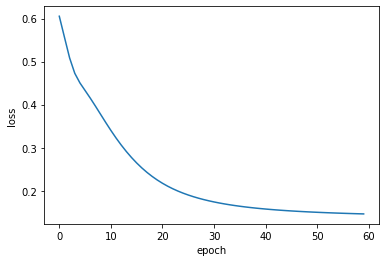

In [14]:
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('loss_conv.png')

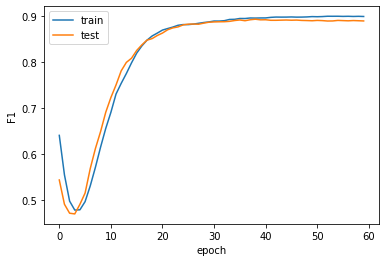

In [15]:
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()
plt.savefig('f1_conv.png')